In [ ]:
import os 
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
from tqdm import tqdm

os.getcwd()


'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Dec 11 00:48:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# path = '/content/drive/MyDrive/CMU Courses/11785 Introduction to Deep Learning/Project'

In [ ]:
# os.chdir(path)

In [ ]:
!ls

detectron2  drive  sample_data


In [ ]:
# from get_feature import *

In [ ]:
# Get_Feature()

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'detectron2' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

In [ ]:
# import importlib
# importlib.reload(SixDRepNet.sixdrepnet)

In [ ]:
# from get_feature import *

In [ ]:
# Get_Feature()

In [ ]:
# test_image_path = '/content/drive/MyDrive/CMU Courses/11785 Introduction to Deep Learning/Project/ami_videos/train0part0.npz' # '/content/drive/MyDrive/Project/ami_videos/train0part0.npz' 
test_image_path = '/content/drive/MyDrive/Project/ami_videos/train0part0.npz' # '/content/drive/MyDrive/Project/ami_videos/train0part0.npz' 

In [ ]:
input = np.load(test_image_path)


tokens = input['input_ids'] # tokens, np.array with shape (1024,)
speakers = input['speaker_ids'] # speaker_ids, np.array with shape (1024,)
closeup1 = input['closeup1'] # image from camera in front of one person, np.array with shape (1024, 288, 352, 3)
closeup2 = input['closeup2'] # image from camera in front of one person, np.array with shape (1024, 288, 352, 3)
closeup3 = input['closeup3'] # image from camera in front of one person, np.array with shape (1024, 288, 352, 3)
closeup4 = input['closeup4'] # image from camera in front of one person, np.array with shape (1024, 288, 352, 3)
corner = input['corner'] # image from camera at corner of rooms, np.array with shape (1024, 288, 352, 3)

In [ ]:
closeup1.shape

(1024, 288, 352, 3)

In [ ]:
# video_path = ['/content/drive/MyDrive/CMU Courses/11785 Introduction to Deep Learning/Project/amicorpus/ES2002a/video/ES2002a.Closeup1.avi',
#               '/content/drive/MyDrive/CMU Courses/11785 Introduction to Deep Learning/Project/amicorpus/ES2002a/video/ES2002a.Closeup2.avi',
#               '/content/drive/MyDrive/CMU Courses/11785 Introduction to Deep Learning/Project/amicorpus/ES2002a/video/ES2002a.Closeup3.avi',
#               '/content/drive/MyDrive/CMU Courses/11785 Introduction to Deep Learning/Project/amicorpus/ES2002a/video/ES2002a.Closeup4.avi']

In [ ]:
# checkpointpath = '/content/drive/MyDrive/CMU Courses/11785 Introduction to Deep Learning/Project/Res50_PureGaze_ETH.pt'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
os.getcwd()

'/content'

In [ ]:
!ls

detectron2  drive  sample_data


In [ ]:
def get_frame(video, word_start_times, word_end_times, frame_definiton='end'):
  """
  inputs: 
    video (cv.VideoCapture) : a video to get a frame 
    word_start_times (float): the starting time of a word
    word_end_times   (float): the ending time of a word
    frame_definiton (str, 'end' or 'middle'): if 'end', it will return the last frame. 
                                              if 'middle', it will return the frame in the middle. 
  """
  # convert times to ms scale
  time_start = float(1000*word_start_times)
  time_end = float(1000*word_end_times)
  
  # get fps
  num_frame = video.get(cv.CAP_PROP_FRAME_COUNT)
  video.set(cv.CAP_PROP_POS_FRAMES, num_frame)
  video_len = video.get(cv.CAP_PROP_POS_MSEC)
  fps = video_len/num_frame
  
  # if we get middle time 
  if frame_definiton == 'middle':
    time_end = (time_start+time_end)/2
# set time to the ending time
  video.set(cv.CAP_PROP_POS_MSEC, time_end-fps)
  available, frame = video.read()
  if available:
    return frame
  else:
    return None

In [ ]:
# # get one image for trial
# word_start_times = 300 # try 200
# word_end_times = 340 # try 230
# video_test = cv.VideoCapture(video_path[1])
# image_test = get_frame(video_test, word_start_times, word_end_times, frame_definiton='end')


In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)


model_final_f10217.pkl: 178MB [00:09, 17.9MB/s]                           


In [ ]:
# build model

model_detectron = build_model(cfg)
DetectionCheckpointer(model_detectron).load(model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # get pretrained weight from model zoo
model_detectron.eval()


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

# Corner

In [ ]:
 def corner_batchver_2(model_detectron, image):
    from detectron2.layers.mask_ops import _do_paste_mask
    
    data_len, height, width, channel = image.shape
    
    # preprocessing for images
    image_trans = torch.from_numpy(image).permute(0,3,1,2)
    images_input = [{f'image': image_trans[i]} for i in range(len(image_trans))]
    
    batch_s = 16
    num_batches = data_len // batch_s
    outputs = []
    i = 0
    updated_images_list = []
    pooled_list = []
    detector_results_list = []
    pbar = tqdm(total = data_len)
    while i < data_len: 

        with torch.no_grad():
    #         output = model_detectron(images_input[i:i+batch_s])
    #         outputs.append(output)
    #         updated_images_list.append(images_input[i:i+batch_s])
            
    #         torch.cuda.empty_cache()
    #         i += batch_s
            # print(len(images_input[i:i+batch_s]))

            # minibatch the image
            print(i)
            print(np.array(images_input[i:i+batch_s]).shape)
            detector_results = model_detectron(images_input[i:i+batch_s])

            print(detector_results)
            print(len(detector_results))
            
            pbar.update(batch_s)

            detector_results_list.append(detector_results)

            # for each detector result, create a pooled vector
            for b in range(len(detector_results)):
                
                # print(f'processing batch {b+1}')
                print(detector_results[b])
                person = detector_results[b]['instances'].pred_classes == 0

                N = len(detector_results[b]['instances'].pred_masks[person])
                if N > 0: # if there is a person detected we add value to the zero array 
                    chunks = torch.chunk(torch.arange(N), N)
                    masks = detector_results[b]['instances'].pred_masks[person, ..., :, :]
                    boxes = detector_results[b]['instances'].pred_boxes.tensor[person]
                    img_masks = torch.zeros(N, height, width).cuda()

                    for inds in chunks:
                        masks_chunk, spatial_inds = _do_paste_mask(masks[inds], boxes[inds], height, width, True)
                        # print(inds.dtype, masks_chunk.dtype, spatial_inds.dtype, img_masks.dtype)
                        img_masks[(inds,) + spatial_inds] = masks_chunk
                    img_masks = torch.sum(img_masks, dim=0)
                else:
                    print('batch_id',i ,'b', b)
                    print(detector_results[b])


                pooled = torch.nn.functional.max_pool2d(img_masks.unsqueeze(0).unsqueeze(0), 4)
                pooled = torch.squeeze(pooled)
                pooled_flat = torch.flatten(pooled)
                # print(pooled.shape)
                pooled_list.append(pooled_flat)
            i += batch_s
                

    
    # stack the list
    pooled_stack = torch.stack(pooled_list)
    pbar.close()

    return detector_results_list, pooled_stack, updated_images_list

In [ ]:
 def corner_batchver(predictor, image):
    from detectron2.layers.mask_ops import _do_paste_mask
    from detectron2.modeling.meta_arch import GeneralizedRCNN
    
    data_len, height, width, channel = image.shape
    
    # preprocessing for images
    images_input = []
    for i in range(data_len):
        in_img = predictor.aug.get_transform(image[i]).apply_image(image[i])
        images_input.append({'image':torch.from_numpy(np.transpose(in_img, (2, 0, 1))), 'height': height, 'width': width})
    
    batch_s = 16
    num_batches = data_len // batch_s
    outputs = []
    i = 0
    updated_images_list = []
    pooled_list = []
    detector_results_list = []
    pbar = tqdm(total = data_len)
    while i < data_len: 

        with torch.no_grad():

            # minibatch the image
            #print(i)
            #print(np.array(images_input[i:i+batch_s]).shape)
            images = predictor.model.preprocess_image(images_input[i:i+batch_s])
            updated_images_list.append(images_input[i:i+batch_s])
            features = predictor.model.backbone(images.tensor)
            proposals, _ = predictor.model.proposal_generator(images, features)
            detector_results, _ = predictor.model.roi_heads(images, features, proposals)
            detector_results = GeneralizedRCNN._postprocess(detector_results, images_input[i:i+batch_s], images.image_sizes)

            # print(detector_results)
            # print(len(detector_results))
            
            pbar.update(batch_s)

            detector_results_list.append(detector_results)
            

            # for each detector result, create a pooled vector
            for b in range(len(detector_results)):
                
                # print(f'processing batch {b+1}')
                
                #person = detector_results[b].pred_classes == 0
                person = detector_results[b]['instances'].pred_classes == 0

                
                N = len(detector_results[b]['instances'].pred_masks[person])
                if N > 0: # if there is a person detected we add value to the zero array
                    """ 
                    chunks = torch.chunk(torch.arange(N), N)
                    masks = detector_results[b].pred_masks[person, ..., :, :]
                    boxes = detector_results[b].pred_boxes.tensor[person]
                    img_masks = torch.zeros(N, height, width).cuda()

                    for inds in chunks:
                        masks_chunk, spatial_inds = _do_paste_mask(masks[inds], boxes[inds], height, width, True)
                        # print(inds.dtype, masks_chunk.dtype, spatial_inds.dtype, img_masks.dtype)
                        img_masks[(inds,) + spatial_inds] = masks_chunk
                    img_masks = torch.sum(img_masks, dim=0)
                    """
                    masks = detector_results[b]['instances'].pred_masks[person, ..., :, :]
                    scores = detector_results[b]['instances'].scores[person]
                    img_masks = torch.sum(masks * scores.unsqueeze(-1).unsqueeze(-1).expand_as(masks), dim=0)
                else:
                    print('batch_id',i ,'b', b)
                    print(detector_results[b])
                


                pooled = torch.nn.functional.max_pool2d(img_masks.unsqueeze(0).unsqueeze(0), 4)
                pooled = torch.squeeze(pooled)
                pooled_flat = torch.flatten(pooled)
                # print(pooled.shape)
                pooled_list.append(pooled_flat)
            i += batch_s
                

    
    # stack the list
    pooled_stack = torch.stack(pooled_list)
    pbar.close()

    return detector_results_list, pooled_stack, updated_images_list

# ---------------------------------------------------------------------------------------------------------
    # pooled_list = []

    # for b in range(len(outputs)):
    #     print(f'processing batch {b+1}')
        
    #     for i in range(len(outputs[b])):
    #         detected_persons = outputs[b][i]
    #         image= updated_images_list[b][i]['image'].permute(1,2,0).numpy()

    #         print('image shape' , image.shape)

    #         # if len(outputs['instances'].pred_boxes)> 0:
    #         person = detected_persons['instances'].pred_classes == 0
    #         N = len(detected_persons['instances'].pred_masks[person])
    #         chunks = torch.chunk(torch.arange(N), N)
    #         print('chunks', chunks)
    #         boxes = detected_persons['instances'].pred_boxes.tensor[person] # onlykeep_person_class(detected_persons, image)
    #         print('boxes', boxes.shape)
    #         masks = detected_persons['instances'].pred_masks
    #         print('masks', masks)
    #         print(masks.shape)
    #         img_masks = torch.zeros(N,  height, width)
    #         print('img_masks',img_masks.shape)
            
    #         for inds in chunks:
    #             print(masks[inds].shape,boxes[inds].shape )
    #             masks_chunk, spatial_inds = _do_paste_mask(masks[inds], boxes[inds], height, width, True)
    #             img_masks[(inds,) + spatial_inds] = masks_chunk
    #             img_masks = torch.sum(img_masks, dim=0)

    #         pooled = torch.nn.functional.max_pool2d(img_masks.unsqueeze(0).unsqueeze(0), 4)
    #         pooled = torch.squeeze(pooled)




    # person = detector_results[0].pred_classes == 0

    # N = len(detector_results[0].pred_masks[person])
    # chunks = torch.chunk(torch.arange(N), N)
    # masks = detector_results[0].pred_masks[person, ..., :, :]
    # boxes = detector_results[0].pred_boxes.tensor[person]
    # img_masks = torch.zeros(N, 288, 344)

    # for inds in chunks:
    #     masks_chunk, spatial_inds = _do_paste_mask(masks[inds], boxes[inds], 288, 344, True)
    #     img_masks[(inds,) + spatial_inds] = masks_chunk
    # img_masks = torch.sum(img_masks, dim=0)






In [ ]:
corner.shape

(1024, 288, 352, 3)

In [ ]:
 def corner_nonbatchver(predictor, images):
    from detectron2.layers.mask_ops import _do_paste_mask
    
    data_len, height, width, channel = images.shape
    
    # preprocessing for images
    image_trans = torch.from_numpy(images)
    images_input = [{f'image': image_trans[i].permute(2,0,1)} for i in range(len(image_trans))]
    # images_input = [{f'image': images[i].permute(2,0,1)} for i in range(len(images))]
    
    batch_s = 16
    num_batches = data_len // batch_s
    outputs = []
    i = 0
    updated_images_list = []
    pooled_list = []
    detector_results_list = []


    
    for i, image in tqdm(enumerate(images_input)): 

        # with torch.no_grad():
            # print(image)
        print(i)
        predictor = DefaultPredictor(cfg)
        images = predictor.model.preprocess_image([image])
        features = predictor.model.backbone(images.tensor)
        proposals, _ = predictor.model.proposal_generator(images, features,)
        detector_results, _ = predictor.model.roi_heads(images, features, proposals,)

        person = detector_results[0].pred_classes == 0



        N = len(detector_results[0].pred_masks[person])
        if N > 0:
            chunks = torch.chunk(torch.arange(N), N)
            masks = detector_results[0].pred_masks[person, ..., :, :]
            boxes = detector_results[0].pred_boxes.tensor[person]
            img_masks = torch.zeros(N, 288, 344).cuda()

            for inds in chunks:
                masks_chunk, spatial_inds = _do_paste_mask(masks[inds], boxes[inds], 288, 344, True)
                img_masks[(inds,) + spatial_inds] = masks_chunk
            img_masks = torch.sum(img_masks, dim=0)
        else:
            print(image)
            print(detector_results)

        

        pooled = torch.nn.functional.max_pool2d(img_masks.unsqueeze(0).unsqueeze(0), 4)
        pooled = torch.squeeze(pooled)
        detector_results_list.append(detector_results)
        

        pooled_flat = torch.flatten(pooled)
        # print(pooled.shape)
        pooled_list.append(pooled)
        del predictor
               

    
    # stack the list
    pooled_stack = torch.stack(pooled_list)

    return detector_results_list, pooled_stack

# ---------------------------------------------------------------------------------------------------------
    # pooled_list = []

    # for b in range(len(outputs)):
    #     print(f'processing batch {b+1}')
        
    #     for i in range(len(outputs[b])):
    #         detected_persons = outputs[b][i]
    #         image= updated_images_list[b][i]['image'].permute(1,2,0).numpy()

    #         print('image shape' , image.shape)

    #         # if len(outputs['instances'].pred_boxes)> 0:
    #         person = detected_persons['instances'].pred_classes == 0
    #         N = len(detected_persons['instances'].pred_masks[person])
    #         chunks = torch.chunk(torch.arange(N), N)
    #         print('chunks', chunks)
    #         boxes = detected_persons['instances'].pred_boxes.tensor[person] # onlykeep_person_class(detected_persons, image)
    #         print('boxes', boxes.shape)
    #         masks = detected_persons['instances'].pred_masks
    #         print('masks', masks)
    #         print(masks.shape)
    #         img_masks = torch.zeros(N,  height, width)
    #         print('img_masks',img_masks.shape)
            
    #         for inds in chunks:
    #             print(masks[inds].shape,boxes[inds].shape )
    #             masks_chunk, spatial_inds = _do_paste_mask(masks[inds], boxes[inds], height, width, True)
    #             img_masks[(inds,) + spatial_inds] = masks_chunk
    #             img_masks = torch.sum(img_masks, dim=0)

    #         pooled = torch.nn.functional.max_pool2d(img_masks.unsqueeze(0).unsqueeze(0), 4)
    #         pooled = torch.squeeze(pooled)




    # person = detector_results[0].pred_classes == 0

    # N = len(detector_results[0].pred_masks[person])
    # chunks = torch.chunk(torch.arange(N), N)
    # masks = detector_results[0].pred_masks[person, ..., :, :]
    # boxes = detector_results[0].pred_boxes.tensor[person]
    # img_masks = torch.zeros(N, 288, 344)

    # for inds in chunks:
    #     masks_chunk, spatial_inds = _do_paste_mask(masks[inds], boxes[inds], 288, 344, True)
    #     img_masks[(inds,) + spatial_inds] = masks_chunk
    # img_masks = torch.sum(img_masks, dim=0)






In [ ]:
    # face_array_list = []
    # for b in range(len(detected_faces_list)):
    #     print(f'processing batch{b+1}')
        
    #     for i in range(len(detected_faces_list[b])):
    #         detected_faces = detected_faces_list[b][i]
    #         image_to_crop = updated_images_list[b][i]['image'].permute(1,2,0).numpy()
    #         print('image shape' , image_to_crop.shape)
    #         if len(detected_faces['instances'].pred_boxes)> 0:
    #             boxes = onlykeep_person_class(detected_faces, image_to_crop)
    #             print(boxes)

In [ ]:
# detector_results_list, pooled_stack, updated_images_list = corner_batchver(predictor, corner) # first 20 images

100%|██████████| 1024/1024 [01:36<00:00, 10.56it/s]


In [ ]:
# updated_images_list[-1][0]['image'].shape

torch.Size([3, 800, 978])

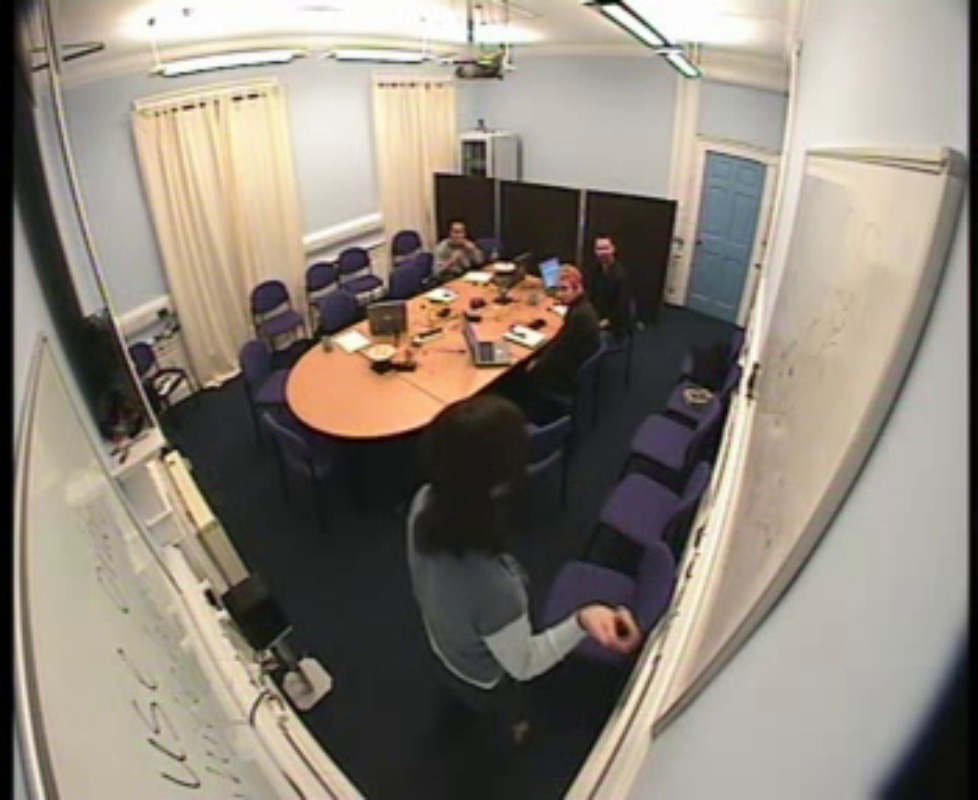

In [ ]:
# cv2_imshow(np.transpose(updated_images_list[-1][0]['image'].numpy(), (1,2,0)))


In [ ]:
# detector_results_list[-1]

[{'instances': Instances(num_instances=12, image_height=288, image_width=352, fields=[pred_boxes: Boxes(tensor([[169.4961, 148.1226, 207.2872, 195.2911],
          [134.4738,  83.2692, 163.2235, 109.7902],
          [101.7586, 102.7708, 208.2915, 158.4268],
          [ 89.4090, 127.3475, 118.5733, 184.8539],
          [ 89.4744, 100.2726, 112.5755, 129.0963],
          [157.4293,  82.8898, 175.3021,  99.3145],
          [130.2997, 123.8016, 143.0064, 131.2404],
          [120.6825,  88.4733, 135.5342, 110.9241],
          [168.2613, 113.6310, 213.1399, 197.4310],
          [202.6633, 148.9386, 251.4355, 201.6411],
          [224.2563, 149.0465, 251.7902, 175.2745],
          [110.2530,  89.3302, 135.1392, 121.1638]], device='cuda:0')), scores: tensor([0.9838, 0.9692, 0.9544, 0.8789, 0.7935, 0.7331, 0.7255, 0.6372, 0.6158,
          0.5209, 0.5155, 0.5123], device='cuda:0'), pred_classes: tensor([56,  0, 60, 56, 56,  0, 45, 56, 56, 56, 56, 56], device='cuda:0'), pred_masks: tensor([[[Fa

In [ ]:
# pooled_stack.shape

torch.Size([1024, 6336])

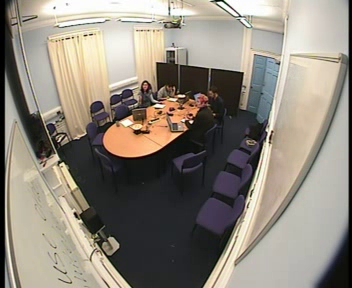

In [ ]:
# cv2_imshow(corner[19])

In [ ]:
# len(detector_results_list)

2

In [ ]:
# detector_results_list[0][15]

{'image': tensor([[[0, 0, 1,  ..., 4, 4, 4],
          [0, 0, 1,  ..., 4, 4, 4],
          [1, 1, 1,  ..., 4, 4, 4],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 2, 2, 2],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[1, 1, 2,  ..., 0, 0, 0],
          [1, 1, 2,  ..., 0, 0, 0],
          [2, 2, 2,  ..., 0, 0, 0],
          ...,
          [2, 2, 2,  ..., 0, 0, 0],
          [2, 2, 2,  ..., 0, 0, 0],
          [2, 2, 2,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'height': 288,
 'width': 352}

In [ ]:
# len(updated_images_list)

NameError: ignored

In [ ]:
# updated_images_list[1][0]['image'].shape

torch.Size([3, 800, 978])

In [ ]:
# len(pooled_stack)

20

In [ ]:
# pooled_stack[16].sum()

tensor(32.9989, device='cuda:0')

In [ ]:
# detector_results_list[0][15]

{'instances': Instances(num_instances=12, image_height=288, image_width=352, fields=[pred_boxes: Boxes(tensor([[134.7410,  82.3655, 163.8639, 109.3688],
         [101.8108, 102.8229, 207.5619, 157.7634],
         [171.5799, 149.5145, 207.3800, 190.3754],
         [ 88.5978, 101.4617, 112.6210, 135.0211],
         [ 90.5219, 131.3974, 119.1300, 182.7059],
         [158.4914,  82.6000, 174.7756,  98.3649],
         [130.2208, 123.8101, 142.9379, 131.3609],
         [111.7318,  88.1073, 135.0177, 121.6965],
         [172.9411, 128.8604, 219.3402, 188.0689],
         [158.0158,  62.9652, 243.9350, 110.0015],
         [205.1074,  91.1628, 225.2746, 128.6661],
         [120.6390,  88.5243, 135.0791, 105.0474]], device='cuda:0')), scores: tensor([0.9769, 0.9474, 0.8926, 0.8122, 0.7909, 0.7370, 0.6999, 0.6934, 0.6636,
         0.6627, 0.5309, 0.5171], device='cuda:0'), pred_classes: tensor([ 0, 60, 56, 56, 56,  0, 45, 56, 56, 62,  0, 56], device='cuda:0'), pred_masks: tensor([[[False, False, F

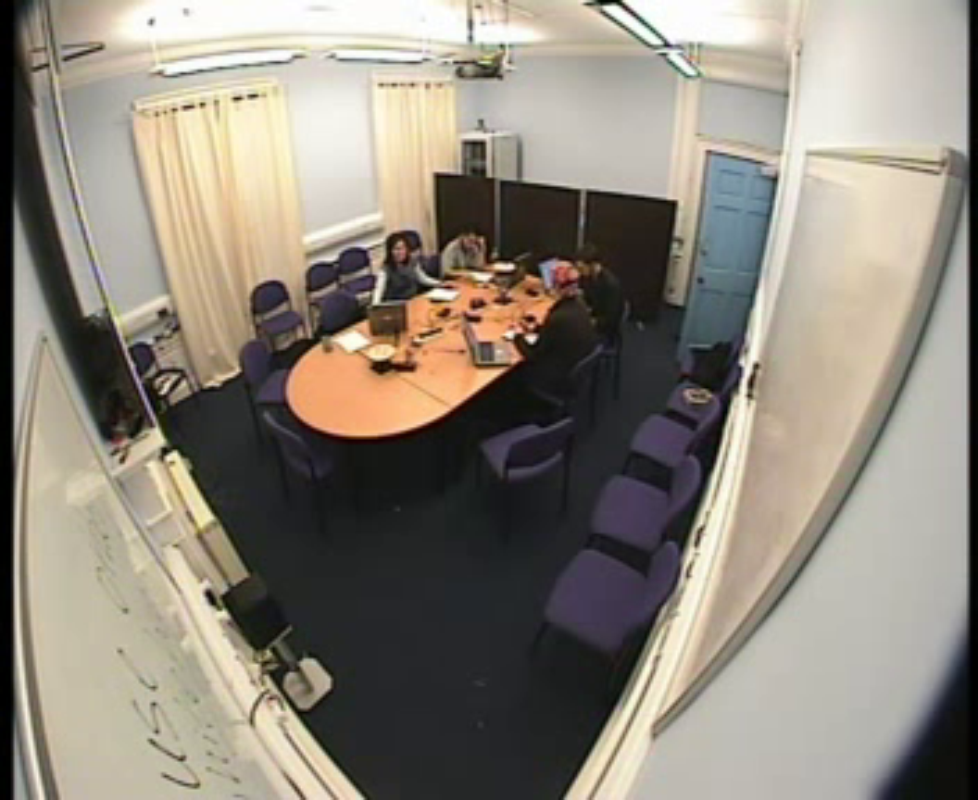

In [ ]:
# cv2_imshow(updated_images_list[0][15]['image'].permute(1,2,0).numpy())

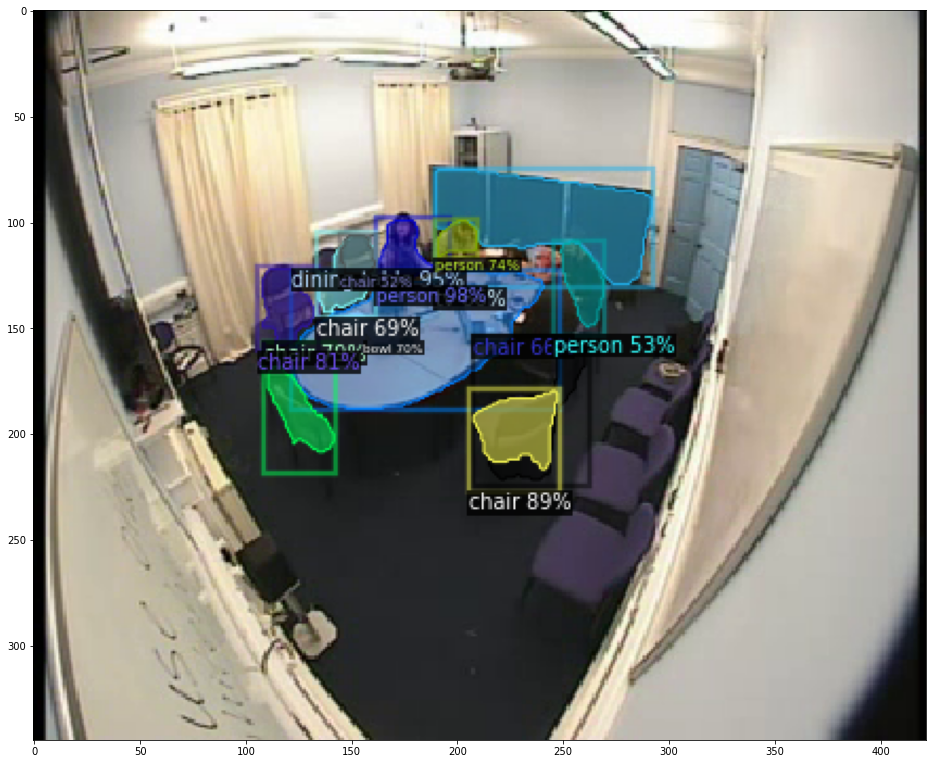

In [ ]:
# v = Visualizer(corner[19], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(detector_results_list[0][15]['instances'].to("cpu"))
# # cv2_imshow(out.get_image()[:, :, ::-1])
# plt.figure(figsize = (16,16))
# plt.imshow(out.get_image()[:, :, ::-1])

# debug Detectron2

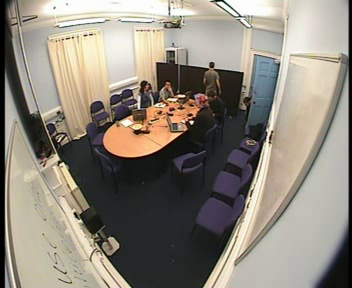

In [ ]:
# cv2_imshow(updated_images_list[0][1]['image'].permute(1,2,0).numpy())

In [ ]:
# cfg = get_cfg()
# # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# predictor = DefaultPredictor(cfg)

tensor([0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[158.5520,  79.9869, 175.0966, 101.4968],
        [202.7988,  61.4350, 221.1082,  95.6673],
        [138.5349,  80.7536, 154.1756, 107.8722],
        [206.5845,  89.4870, 225.5953, 124.4459]], device='cuda:0'))
4


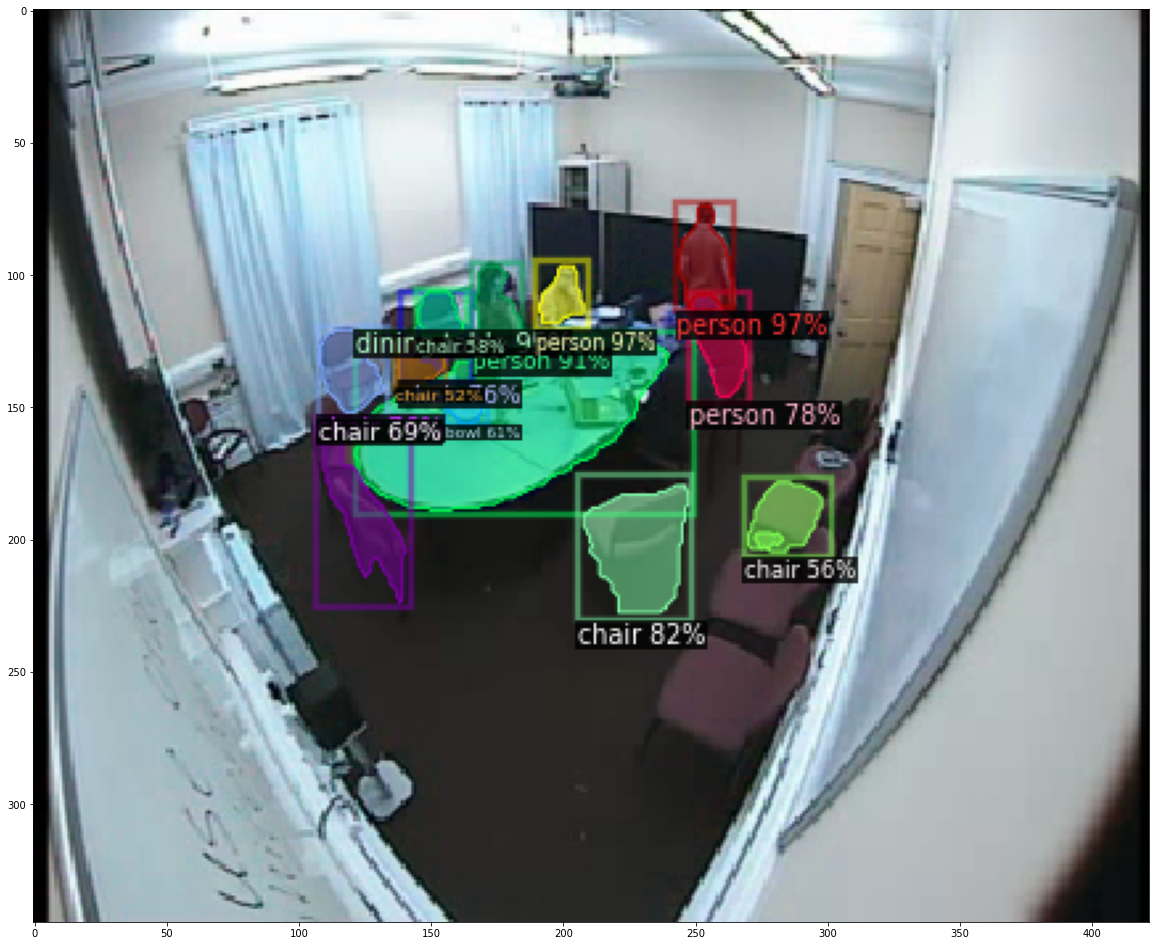

In [ ]:
# # debug
# frame = updated_images_list[0][1]['image'].permute(1,2,0).numpy()

# result = predictor(frame)
# person = result["instances"].pred_classes == 0
# print(result["instances"].pred_classes[person])
# print(result["instances"].pred_boxes[person])
# print(len(result["instances"].pred_masks[person]))
# v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(result["instances"].to("cpu"))
# # cv2_imshow(out.get_image()[:, :, ::-1])
# plt.figure(figsize = (20,20))
# plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
# len(detector_results)

4

In [ ]:
# pooled_stack.shape

torch.Size([1024, 72, 88])

In [ ]:
# detector_results[0]

Instances(num_instances=1, image_height=288, image_width=352, fields=[pred_boxes: Boxes(tensor([[208.7430,  62.4398, 228.2555, 124.0868]], device='cuda:0')), scores: tensor([0.8231], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[[0.0012, 0.0014, 0.0012, 0.0021, 0.0041, 0.0078, 0.0179, 0.0396,
           0.0945, 0.2219, 0.4619, 0.7680, 0.9182, 0.9506, 0.9439, 0.9013,
           0.8126, 0.6517, 0.5122, 0.3128, 0.1337, 0.0591, 0.0206, 0.0089,
           0.0030, 0.0014, 0.0013, 0.0011],
          [0.0024, 0.0034, 0.0035, 0.0067, 0.0140, 0.0257, 0.0581, 0.1229,
           0.2478, 0.5144, 0.7926, 0.9443, 0.9838, 0.9889, 0.9880, 0.9792,
           0.9576, 0.9055, 0.8311, 0.6289, 0.3450, 0.1627, 0.0583, 0.0239,
           0.0084, 0.0036, 0.0028, 0.0018],
          [0.0101, 0.0173, 0.0279, 0.0501, 0.0757, 0.1105, 0.1927, 0.2914,
           0.4957, 0.7040, 0.8904, 0.9664, 0.9885, 0.9910, 0.9891, 0.9796,
           0.9600, 0.9177, 0.8436, 0.6841, 0.4372, 0.26

In [ ]:
# detector_results

[Instances(num_instances=1, image_height=288, image_width=352, fields=[pred_boxes: Boxes(tensor([[202.4406,  61.3234, 227.9401, 125.1395]], device='cuda:0')), scores: tensor([0.7873], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[[9.7009e-04, 1.1530e-03, 2.1013e-03, 4.3924e-03, 1.6600e-02,
            4.1860e-02, 1.2253e-01, 3.1877e-01, 6.4327e-01, 8.2803e-01,
            8.3918e-01, 7.6595e-01, 6.0354e-01, 3.1310e-01, 9.4009e-02,
            2.9649e-02, 6.8493e-03, 2.6020e-03, 7.2356e-04, 3.6700e-04,
            1.7341e-04, 1.0161e-04, 1.4179e-04, 9.3291e-05, 1.2330e-04,
            8.9778e-05, 2.4377e-04, 2.6870e-04],
           [1.8170e-03, 2.5141e-03, 4.8645e-03, 1.0861e-02, 4.0045e-02,
            1.0721e-01, 2.6476e-01, 6.3824e-01, 9.1868e-01, 9.6476e-01,
            9.6283e-01, 9.3349e-01, 8.3615e-01, 5.5172e-01, 2.2549e-01,
            7.2661e-02, 1.9126e-02, 7.2677e-03, 2.3492e-03, 1.1290e-03,
            5.0998e-04, 2.6318e-04, 3.4694e-04

https://detectron2.readthedocs.io/en/latest/modules/modeling.html#detectron2.modeling.GeneralizedRCNN.preprocess_image
https://detectron2.readthedocs.io/en/latest/modules/modeling.html?highlight=proposal%20generator#detectron2.modeling.build_proposal_generator 

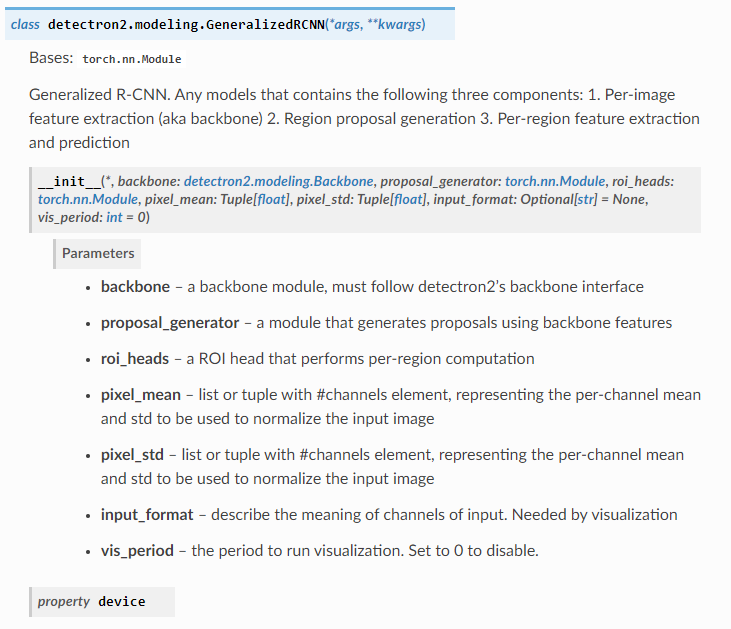

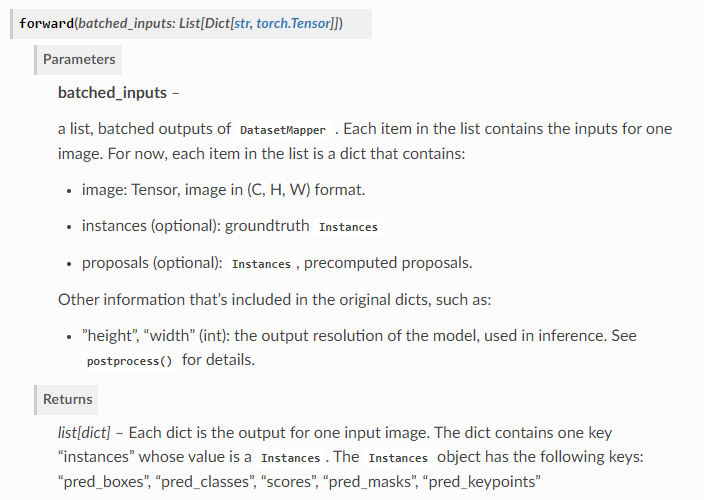

In [ ]:
# # yuya version

# # predictor.model.train()
# # #predictor.model.eval()
# predictor = DefaultPredictor(cfg)
# images = predictor.model.preprocess_image([{'image':torch.from_numpy(np.transpose(corner[0], (2, 0, 1)))}])
# features = predictor.model.backbone(images.tensor)
# proposals, _ = predictor.model.proposal_generator(images, features, None, False)
# detector_results, _ = predictor.model.roi_heads(images, features, proposals, None, False)

# person = detector_results[0].pred_classes == 0

# from detectron2.layers.mask_ops import _do_paste_mask

# N = len(detector_results[0].pred_masks[person])
# chunks = torch.chunk(torch.arange(N), N)
# masks = detector_results[0].pred_masks[person, ..., :, :]
# boxes = detector_results[0].pred_boxes.tensor[person]
# img_masks = torch.zeros(N, 288, 344)

# for inds in chunks:
#     masks_chunk, spatial_inds = _do_paste_mask(masks[inds], boxes[inds], 288, 344, True)
#     img_masks[(inds,) + spatial_inds] = masks_chunk
# img_masks = torch.sum(img_masks, dim=0)


# pooled = torch.nn.functional.max_pool2d(img_masks.unsqueeze(0).unsqueeze(0), 4)
# pooled = torch.squeeze(pooled)


R-50.pkl: 102MB [00:01, 66.5MB/s]                            

[12/08 18:42:42 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[12/08 18:42:42 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  


backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


TypeError: ignored

In [ ]:
pooled.shape

# closeup

In [ ]:
# preprocessing for images
closeup_trans = torch.from_numpy(closeup1).permute(0,3,1,2)
images_input = [{f'image': closeup_trans[i]} for i in range(len(closeup_trans))]


In [ ]:
images_input[0]['image'].shape

torch.Size([3, 288, 352])

In [ ]:
import time

In [ ]:
st = time.time()
batch_s = 16
num_batches = 1024 // batch_s
outputs = []
i = 0
data_len = 1024
while i < data_len: 
    with torch.no_grad():
        output = model_detectron(images_input[i:i+batch_s])
        outputs.append(output)
        torch.cuda.empty_cache()
        i += batch_s
        
print('time elapsed for one closesup', time.time() - st)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


time elapsed for one closesup 34.92423725128174


In [ ]:
closeup1.shape

(1024, 288, 352, 3)

In [ ]:
# sanity check

print('num_batch', len(outputs)) 
print('batch_size',len(outputs[0]))

num_batch 64
batch_size 16


In [ ]:
outputs[0][3]

{'instances': Instances(num_instances=2, image_height=288, image_width=352, fields=[pred_boxes: Boxes(tensor([[ 74.2551, 118.5122, 266.2297, 283.4184],
         [317.2462, 250.0961, 349.6203, 287.5491]], device='cuda:0')), scores: tensor([0.9976, 0.8521], device='cuda:0'), pred_classes: tensor([ 0, 39], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],
 
         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  

In [ ]:
# outputs = predictor(image_test)

In [ ]:
# outputs[1]['instances'].pred_boxes

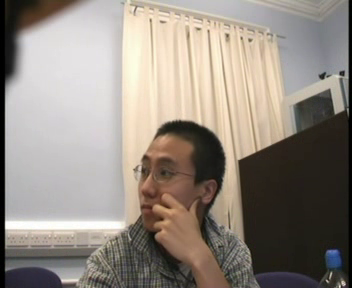

In [ ]:
cv2_imshow(images_input[1]['image'].permute(1,2,0).numpy())

In [ ]:
len(images_input)

1024

In [ ]:
num_batches

64

In [ ]:
# ((image_id + 1)// batch_s) * batch_s

In [ ]:
# image_id // batch_s

In [ ]:
b = 0
i = 0

image_id = 16 # range 0 - 1024
if image_id == 0:
    b = 0
    i = 0
elif (image_id// batch_s * batch_s) > 0 :
    b = image_id // batch_s 
    i = (image_id - (b*batch_s))
    b = b 
else:
    b = image_id // batch_s
    i = image_id
    
print('image_id:', image_id, 'b:', b , 'i:', i)

image_id: 16 b: 1 i: 0


In [ ]:
from detectron2.structures import Boxes
def onlykeep_person_class(outputs , image):
  cls = outputs['instances'].pred_classes
  scores = outputs["instances"].scores
  boxes = outputs['instances'].pred_boxes

  # index to keep whose class == 0
  indx_to_keep = (cls == 0).nonzero().flatten().tolist()
    
  # only keeping index  corresponding arrays

  boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))
  
#   # create new instance obj and set its fields
#   obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
#   obj.set('pred_boxes',boxes1)
  return boxes1

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs[b][i]["instances"].pred_classes)
print(outputs[b][i]["instances"].pred_boxes)

tensor([ 0, 39], device='cuda:0')
Boxes(tensor([[ 81.6553, 134.3452, 263.4253, 283.9579],
        [318.1989, 249.1277, 348.4685, 287.7438]], device='cuda:0'))


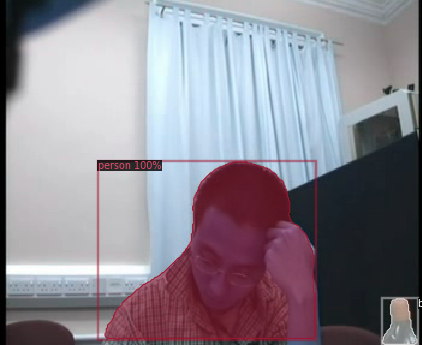

In [ ]:
# verify boxes are correect when using model and batch size

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(images_input[image_id]['image'].permute(1,2,0), MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs[b][i]["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
outputs[0][0]

{'instances': Instances(num_instances=4, image_height=288, image_width=352, fields=[pred_boxes: Boxes(tensor([[ 79.5072, 120.4302, 251.4210, 283.3933],
         [205.3488,  99.5371, 246.3881, 241.6249],
         [317.9537, 250.2344, 349.4379, 287.6968],
         [  1.1828, 190.4306,  62.6221, 287.8250]], device='cuda:0')), scores: tensor([0.9959, 0.9365, 0.8599, 0.7895], device='cuda:0'), pred_classes: tensor([ 0,  0, 39,  0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],
 
         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., Fals

In [ ]:
closeup1.shape

(1024, 288, 352, 3)

In [ ]:
# expand dimension of closeup and combine with vstack

closeup_stacked = np.vstack((
    np.expand_dims(closeup1, 0), 
    np.expand_dims(closeup2, 0), 
    np.expand_dims(closeup3, 0),
    np.expand_dims(closeup4, 0)
))

In [ ]:
closeup_stacked.shape

(4, 1024, 288, 352, 3)

In [ ]:
# # detectron face detection for batch and detectron model version

# predictor = DefaultPredictor(cfg)
# outputs = predictor(image_test)

# outputs['instances'][0].pred_boxes


def crop_face_detectron_batchver(model_detectron, final_shape, image):
    """
    function for cropping picture with face in the center (if face is detected), else center crop
    Input:
        detect_faces: function for face detection, will return face frame if face are detected
        final_shape: image output shape (H,W) channel will be added automatically
        image: tensor of image file

    """
    print('Running crop face')
    data_len, width, height, channel = image.shape   # Get dimensions

    # preprocessing for images
    image_trans = torch.from_numpy(image).permute(0,3,1,2)
    images_input = [{f'image': image_trans[i]} for i in range(len(image_trans))]
    print('1. Finished preprocessing')
        
    # run thru detectron
    batch_s = 16
    num_batches = data_len // batch_s
    detected_faces_list = []
    i = 0


    updated_images_list = []
    while i < data_len: 
        with torch.no_grad():
            output = model_detectron(images_input[i:i+batch_s])
            detected_faces_list.append(output)
            updated_images_list.append(images_input[i:i+batch_s])
            torch.cuda.empty_cache()
            i += batch_s
    print('2. Finished prediction by Detectron2')
    
    # detected_faces_list is a list of list tensor (64 x 16), each element in list is `instance` dictionary output from detectron
   

    # get face crop (have to loop over because the detectron output is dictionary)

    face_array_list = []
    for b in range(len(detected_faces_list)):
        print(f'processing batch{b+1}')
        
        for i in range(len(detected_faces_list[b])):
            detected_faces = detected_faces_list[b][i]
            image_to_crop = updated_images_list[b][i]['image'].permute(1,2,0).numpy()
            print('image shape' , image_to_crop.shape)
            if len(detected_faces['instances'].pred_boxes)> 0:
                boxes = onlykeep_person_class(detected_faces, image_to_crop)
                print(boxes)
                if len(boxes)> 1:
                    # boxes = detected_faces['instances'].pred_boxes
                    boxes = boxes.tensor
                    print(boxes.shape)
                    # Crop faces and plot
                    if (boxes[0][2] -  boxes[0][0]) > (boxes[1][2] - boxes[1][0]):
                        pass
                    else:
                        boxes = boxes[1:]
                if len(boxes)> 0:

                    for n, face_rect in enumerate(boxes):
                        print('face_rect', face_rect)
                        face_rect = face_rect.cpu().numpy()
                        mid_x = face_rect[0] + (face_rect[2] - face_rect[0])//2 # midpoint
                        mid_y = face_rect[1] + (face_rect[3] - face_rect[1])//2 # midpoint
                        left = mid_x - (final_shape[0]//2)
                        top = mid_y - (final_shape[1]//2)
                        
                        # c = mid_x + (final_shape[0]//2)
                        # d = mid_y + (final_shape[1]//2)
                        right = left + final_shape[0]
                        bottom = top + final_shape[1]
                        face_rect_new = (left, top, right, bottom)
                        print(face_rect_new)
                        # # face = image[bottom:right, b:d]
                        # ori_face = image[face_rect[0]:face_rect[2] , face_rect[1]: face_rect[3]]
                        # Image.fromarray(face)
                        # plt.subplot(1, len(detected_faces), n+1)
                        # plt.axis('off')
                        # plt.imshow(face)
                        
                        face = Image.fromarray(image_to_crop).crop(face_rect_new)
                        
                        face_array = np.array(face)
                        print(face_array.shape)
                        plt.imshow(face)
                        face_array_list.append(face_array)
                
                        break
                else:
                    # if cannot detect face , crop center
 

                    new_width, new_height = final_shape
                    left = (width - new_width)//2
                    top = (height - new_height)//2
                    right = (width + new_width)//2
                    bottom = (height + new_height)//2
                    face_rect_new = (left, top, right, bottom)
                    print(face_rect_new)

                    # Crop the center of the image
                    face = Image.fromarray(image_to_crop).crop(face_rect_new)
                    face_array = np.array(face)
                    print(face_array.shape)
                    # plt.imshow(face)
                    face_array_list.append(face_array)
                
            else:
                            # if cannot detect face , crop center

                new_width, new_height = final_shape
                left = (width - new_width)//2
                top = (height - new_height)//2
                right = (width + new_width)//2
                bottom = (height + new_height)//2
                face_rect_new = (left, top, right, bottom)
                print(face_rect_new)

                # Crop the center of the image
                face = Image.fromarray(image_to_crop).crop(face_rect_new)
                face_array = np.array(face)
                print(face_array.shape)
                plt.imshow(face)
                face_array_list.append(face_array)
                
    # else:
    #     if len(detected_faces)> 0:
    #         boxes = detected_faces
    #         # Crop faces and plot
    #         for n, face_rect in enumerate(boxes):
    #             print('face_rect', face_rect)
    #             face_rect = face_rect.cpu().numpy()
    #             mid_x = face_rect[0] + (face_rect[2] - face_rect[0])//2 # midpoint
    #             mid_y = face_rect[1] + (face_rect[3] - face_rect[1])//2 # midpoint
    #             left = mid_x - (final_shape[0]//2)
    #             top = mid_y - (final_shape[1]//2)
                
    #             # c = mid_x + (final_shape[0]//2)
    #             # d = mid_y + (final_shape[1]//2)
    #             right = left + final_shape[0]
    #             bottom = top + final_shape[1]
    #             face_rect_new = (left, top, right, bottom)
    #             print(face_rect_new)
    #             # # face = image[bottom:right, b:d]
    #             # ori_face = image[face_rect[0]:face_rect[2] , face_rect[1]: face_rect[3]]
    #             # Image.fromarray(face)
    #             # plt.subplot(1, len(detected_faces), n+1)
    #             # plt.axis('off')
    #             # plt.imshow(face)
                
    #             face = Image.fromarray(image).crop(face_rect_new)
                
    #             face_array = np.array(face)
    #             print(face_array.shape)
    #             plt.imshow(face)
    #             break
    #     else:
    #         # if cannot detect face , crop center
    #         width, height, _ = image.shape   # Get dimensions

    #         new_width, new_height = final_shape
    #         left = (width - new_width)//2
    #         top = (height - new_height)//2
    #         right = (width + new_width)//2
    #         bottom = (height + new_height)//2
    #         face_rect_new = (left, top, right, bottom)
    #         print(face_rect_new)

    #         # Crop the center of the image
    #         face = Image.fromarray(image).crop(face_rect_new)
    #         face_array = np.array(face)
    #         print(face_array.shape)
    #         plt.imshow(face)
        
    return face_array_list


In [ ]:
# # # detectron face detection

# # predictor = DefaultPredictor(cfg)
# # outputs = predictor(image_test)

# # outputs['instances'][0].pred_boxes


# def crop_face_detectron(detect_faces, final_shape, image):
#     """
#     function for cropping picture with face in the center (if face is detected), else center crop
#     Input:
#         detect_faces: function for face detection, will return face frame if face are detected
#         final_shape: image output shape (H,W) channel will be added automatically
#         image: np.array of image file

#     """
    
    
#     detected_faces = detect_faces(image)

#     if type(detect_faces) == detectron2.engine.defaults.DefaultPredictor:
#         if len(detected_faces['instances'].pred_boxes)> 0:
#             boxes = onlykeep_person_class(detected_faces, image)
#             print(boxes)
#             if len(boxes)> 1:
#                 # boxes = detected_faces['instances'].pred_boxes
#                 boxes = boxes.tensor
#                 print(boxes.shape)
#                 # Crop faces and plot
#                 if (boxes[0][2] -  boxes[0][0]) > (boxes[1][2] - boxes[1][0]):
#                     pass
#                 else:
#                     boxes = boxes[1:]
#             if len(boxes)> 0:

#                 for n, face_rect in enumerate(boxes):
#                     print('face_rect', face_rect)
#                     face_rect = face_rect.cpu().numpy()
#                     mid_x = face_rect[0] + (face_rect[2] - face_rect[0])//2 # midpoint
#                     mid_y = face_rect[1] + (face_rect[3] - face_rect[1])//2 # midpoint
#                     left = mid_x - (final_shape[0]//2)
#                     top = mid_y - (final_shape[1]//2)
                    
#                     # c = mid_x + (final_shape[0]//2)
#                     # d = mid_y + (final_shape[1]//2)
#                     right = left + final_shape[0]
#                     bottom = top + final_shape[1]
#                     face_rect_new = (left, top, right, bottom)
#                     print(face_rect_new)
#                     # # face = image[bottom:right, b:d]
#                     # ori_face = image[face_rect[0]:face_rect[2] , face_rect[1]: face_rect[3]]
#                     # Image.fromarray(face)
#                     # plt.subplot(1, len(detected_faces), n+1)
#                     # plt.axis('off')
#                     # plt.imshow(face)
                    
#                     face = Image.fromarray(image).crop(face_rect_new)
                    
#                     face_array = np.array(face)
#                     print(face_array.shape)
#                     plt.imshow(face)
#                     break
#             else:
#                 # if cannot detect face , crop center
#                 width, height, _ = image.shape   # Get dimensions

#                 new_width, new_height = final_shape
#                 left = (width - new_width)//2
#                 top = (height - new_height)//2
#                 right = (width + new_width)//2
#                 bottom = (height + new_height)//2
#                 face_rect_new = (left, top, right, bottom)
#                 print(face_rect_new)

#                 # Crop the center of the image
#                 face = Image.fromarray(image).crop(face_rect_new)
#                 face_array = np.array(face)
#                 print(face_array.shape)
#                 plt.imshow(face)
            
#         else:
#                         # if cannot detect face , crop center
#             width, height, _ = image.shape   # Get dimensions

#             new_width, new_height = final_shape
#             left = (width - new_width)//2
#             top = (height - new_height)//2
#             right = (width + new_width)//2
#             bottom = (height + new_height)//2
#             face_rect_new = (left, top, right, bottom)
#             print(face_rect_new)

#             # Crop the center of the image
#             face = Image.fromarray(image).crop(face_rect_new)
#             face_array = np.array(face)
#             print(face_array.shape)
#             plt.imshow(face)
            
#     else:
#         if len(detected_faces)> 0:
#             boxes = detected_faces
#             # Crop faces and plot
#             for n, face_rect in enumerate(boxes):
#                 print('face_rect', face_rect)
#                 face_rect = face_rect.cpu().numpy()
#                 mid_x = face_rect[0] + (face_rect[2] - face_rect[0])//2 # midpoint
#                 mid_y = face_rect[1] + (face_rect[3] - face_rect[1])//2 # midpoint
#                 left = mid_x - (final_shape[0]//2)
#                 top = mid_y - (final_shape[1]//2)
                
#                 # c = mid_x + (final_shape[0]//2)
#                 # d = mid_y + (final_shape[1]//2)
#                 right = left + final_shape[0]
#                 bottom = top + final_shape[1]
#                 face_rect_new = (left, top, right, bottom)
#                 print(face_rect_new)
#                 # # face = image[bottom:right, b:d]
#                 # ori_face = image[face_rect[0]:face_rect[2] , face_rect[1]: face_rect[3]]
#                 # Image.fromarray(face)
#                 # plt.subplot(1, len(detected_faces), n+1)
#                 # plt.axis('off')
#                 # plt.imshow(face)
                
#                 face = Image.fromarray(image).crop(face_rect_new)
                
#                 face_array = np.array(face)
#                 print(face_array.shape)
#                 plt.imshow(face)
#                 break
#         else:
#             # if cannot detect face , crop center
#             width, height, _ = image.shape   # Get dimensions

#             new_width, new_height = final_shape
#             left = (width - new_width)//2
#             top = (height - new_height)//2
#             right = (width + new_width)//2
#             bottom = (height + new_height)//2
#             face_rect_new = (left, top, right, bottom)
#             print(face_rect_new)

#             # Crop the center of the image
#             face = Image.fromarray(image).crop(face_rect_new)
#             face_array = np.array(face)
#             print(face_array.shape)
#             plt.imshow(face)
        
#     return face_array


Running crop face
1. Finished preprocessing
2. Finished prediction by Detectron2
processing batch1
image shape (288, 352, 3)
Boxes(tensor([[ 79.5072, 120.4302, 251.4210, 283.3933],
        [205.3488,  99.5372, 246.3881, 241.6248],
        [  1.1828, 190.4307,  62.6221, 287.8250]]))
torch.Size([3, 4])
face_rect tensor([ 79.5072, 120.4302, 251.4210, 283.3933])
(64.50721740722656, 101.43021392822266, 264.50721740722656, 301.43021392822266)
(200, 200, 3)
image shape (288, 352, 3)
Boxes(tensor([[ 76.2521, 120.3520, 260.3759, 283.1460]]))
face_rect tensor([ 76.2521, 120.3520, 260.3759, 283.1460])
(68.25210571289062, 101.35202026367188, 268.2521057128906, 301.3520202636719)
(200, 200, 3)
image shape (288, 352, 3)
Boxes(tensor([[ 71.3418, 114.9373, 260.4162, 283.0104]]))
face_rect tensor([ 71.3418, 114.9373, 260.4162, 283.0104])
(65.34180450439453, 98.937255859375, 265.34180450439453, 298.937255859375)
(200, 200, 3)


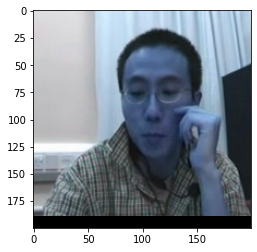

In [ ]:
final_shape = (200,200)
face_array_list = crop_face_detectron_batchver(model_detectron,  final_shape, closeup1[:3])

In [ ]:
len(face_array_list)

3

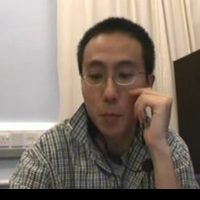

In [ ]:
cv2_imshow(face_array_list[2])

In [ ]:
# os.chdir('/content/drive/MyDrive/CMU Courses/11785 Introduction to Deep Learning/Project/SixDRepNet')  # for importing 6DRepNet
os.chdir('/content/drive/MyDrive/Project/SixDRepNet')  # for importing 6DRepNet

In [ ]:
face_tensor = torch.from_numpy(np.array(face_array_list)).permute(0,3,1,2).type(torch.FloatTensor)

In [ ]:
face_tensor.shape

torch.Size([3, 3, 200, 200])

In [ ]:
# import importlib
# importlib.reload(sixdrepnet)

In [1]:
import sixdrepnet
from sixdrepnet.regressor import SixDRepNet_Detector

ModuleNotFoundError: ignored

In [ ]:
# from  sixdrepnet import SixDRepNet
# from SixDRepNet import sixdrepnet
# from SixDRepNet.sixdrepnet import model
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

# Create model
# Weights are automatically downloaded
model = SixDRepNet_Detector()

# define final shape
final_shape = (200,200) # 200, 200 is good for head pose detection task 

# face_array = crop_face_detectron(predictor,  final_shape, image_test)

out_list = []
x_list = []

# not enough cuda here
# for i in range(len(face_tensor)):    
#     out, x = model.predict(face_tensor[i])
#     out_list.append(out)
#     x_list.append(x)

# if GPU good, try predict_batch
out_tensor, x_tensor = model.predict_batch(face_tensor)



In [ ]:
x_tensor

In [ ]:
out_tensor

In [ ]:
# from  sixdrepnet import SixDRepNet
# from SixDRepNet import sixdrepnet
# from SixDRepNet.sixdrepnet import model
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

# Create model
# Weights are automatically downloaded
model = sixdrepnet.SixDRepNet()

# define final shape
final_shape = (200,200) # 200, 200 is good for head pose detection task 

# face_array = crop_face_detectron(predictor,  final_shape, image_test)

out_list = []
x_list = []

# not enough cuda here
for i in range(len(face_tensor)):    
    out, x = model.predict(face_tensor[i])
    out_list.append(out)
    x_list.append(x)

# if GPU good, try predict_batch
# out_tensor, x_tensor = model.predict_batch(face_tensor)



In [ ]:
out_list

In [ ]:
x_list

In [ ]:
from  sixdrepnet import SixDRepNet
# from SixDRepNet import sixdrepnet
# from SixDRepNet.sixdrepnet import model
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

# Create model
# Weights are automatically downloaded
model = SixDRepNet()

# define final shape
final_shape = (200,200) # 200, 200 is good for head pose detection task 

# face_array = crop_face_detectron(predictor,  final_shape, image_test)
    
(pitch, yaw, roll), x = model.predict(face_array)
image_test_draw = face_array.copy()
image_test_draw = model.draw_axis(image_test_draw, yaw, pitch, roll)

cv2_imshow(image_test_draw)
cv2.waitKey(0)


In [ ]:
print(x.shape)

In [ ]:
x.shape

In [ ]:
# try time stamp (100, 140), (200, 230) , (300, 340), (500, 540), 

word_start_times , word_end_times = 800, 840 # try 230
final_shape = (200, 200)

original_images_lst = []
output_images_lst = []
features_lst = []


for i in range(4):
    video_test = cv.VideoCapture(video_path[i])

    image_test = get_frame(video_test, word_start_times, word_end_times, frame_definiton='end')
    image = Image.fromarray(image_test)
    
    # # sharpen image
    # enhancer = ImageEnhance.Sharpness(image)
    # image_sharpened = enhancer.enhance(2)
    # image_sharpened_array = np.array(image_sharpened)
    # face_array = crop_face_detectron(predictor,  final_shape, image_sharpened_array)
    
    # # preprocessing for pytroch inference
    # image_test_tensor = torch.from_numpy(face_array).type(torch.FloatTensor)
    # image_test_tensor = image_test_tensor.permute(2,1,0)
    # image_test_tensor = image_test_tensor.expand(1, -1, -1, -1)
    # image_test_tensor = image_test_tensor.to(device)

    face_array = crop_face_detectron(predictor,  final_shape, image_test)


    # inference
    (pitch, yaw, roll), x = model.predict(face_array)
    image_test_draw = face_array.copy()

    model.draw_axis(image_test_draw, yaw, pitch, roll)

    # store results to lists
    original_images_lst.append(image_test)
    output_images_lst.append(image_test_draw)
    features_lst.append(x)


In [ ]:
for i in range(4):
    print(i+1, ':',word_start_times ,'-', word_end_times )
    cv2_imshow(original_images_lst[i])
    cv2_imshow(output_images_lst[i])
